In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
save_dir = "diffusion_training_data/"
#save_dir = '/content/drive/MyDrive/ai ai pong/'+ save_dir


In [5]:
from torchvision.models import resnet18

In [6]:
# !pip install torchvision
# !pip install tensorboard
# !pip uninstall conditional_diffusion

#install torch with cuda
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/stevenharperja/conditional_diffusion.git#egg=conditional_diffusion


Looking in indexes: https://download.pytorch.org/whl/cu118
  Cloning https://github.com/stevenharperja/conditional_diffusion.git to c:\users\shwes\appdata\local\temp\pip-install-3eari01r\conditional-diffusion_fd7e75f5ce2a473da8d63931c78be3a0
  Resolved https://github.com/stevenharperja/conditional_diffusion.git to commit ce480bac794a41df4a5e88f5d7e04dba876b7fc4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/stevenharperja/conditional_diffusion.git 'C:\Users\shwes\AppData\Local\Temp\pip-install-3eari01r\conditional-diffusion_fd7e75f5ce2a473da8d63931c78be3a0'


In [7]:
torch.cuda.is_available()
import torch

In [8]:
!pip install tensorboard
import conditional_diffusion.modules as modules
from conditional_diffusion.ddpm_conditional import Diffusion as Diffusion
import conditional_diffusion.utils as utils
import torch

In [9]:
from tqdm import tqdm 
class Net(nn.Module):
    def __init__(self, device, embedding_scale = 0):
        super(Net, self).__init__()
        self.embedding_scale = embedding_scale

        resnet = resnet18(weights="IMAGENET1K_V1")
        resnet.fc = nn.Identity()
        #freeze the weights for resnet
        for param in resnet.parameters():
            param.requires_grad = False

        ###init and modify diffusion model
        diffusion_model = modules.UNet_conditional(num_classes=10).to(device)
        ckpt = torch.load("models/conditional_ema_ckpt.pt", map_location=device)
        diffusion_model.load_state_dict(ckpt)
        #remove nn.embedder and just send an embedding instead
        diffusion_model.label_emb = nn.Identity()
        #freeze the weights for diffusion model
        for param in diffusion_model.parameters():
            param.requires_grad = False
        #unfreeze all of the diffusion model's decoder layers
        # diffusion_model.up1.requires_grad = True
        # diffusion_model.sa4.requires_grad = True
        # diffusion_model.up2.requires_grad = True
        # diffusion_model.sa5.requires_grad = True
        diffusion_model.up3.requires_grad = True #unfreeze just the last 3 layers of diffusion model
        diffusion_model.sa6.requires_grad = True
        diffusion_model.outc.requires_grad = True

        ###init upscaler model
        upscaler = nn.Sequential(
            nn.Upsample(size=(224,224), mode="bilinear", align_corners=True),
        )

        #input of (N, 3, 224, 224), output of (N, 256)
        self.encoder = nn.Sequential(
            resnet,
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0), #Using a layer which isnt trainable so I can reduce the size while keeping it frozen.
        )
        
        self.diffusion_model = diffusion_model #input of (N,256) output of (N,3,64,64)
        self.upscaler = upscaler
        self.final_layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, stride=1, padding=0) # reduce channel size to 1 for black and white
        #input of (N, 256), output of (N, 1)
        self.reward_maker = nn.Sequential(
            nn.Linear(in_features=256, out_features=1),
        )
        #input of (N, 256), output of (N, 1)
        self.done_maker = nn.Sequential(
            nn.Linear(in_features=256, out_features=1),
        )


        ###variables for the diffusion model
        self.noise_steps = 1000
        self.beta_start = 1e-4
        self.beta_end = 0.02
        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.device = device
        self.zero_embedding = torch.zeros((1,256)).to(self.device) 


    #prediction function. this may not work for training. but maybe since its pretrained it might? work
    def diffusion_sample(self, embedding): # see https://github.com/stevenharperja/conditional_diffusion/blob/main/conditional_diffusion/ddpm_conditional.py#L41
        n = embedding.size()[0]
        x = torch.randn((n, 3, 64, 64)).to(self.device)
        for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            t = (torch.ones(n) * i).long().to(self.device)
            predicted_noise = self.diffusion_model(x, t, embedding)
            if self.embedding_scale > 0:
                uncond_predicted_noise = self.diffusion_model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, self.embedding_scale)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        return x


    def forward(self, x, t = None, noised_truth = None, use_embedding = True):
        """
        
        x: The input image (n,3,224,224)
        t: The timesteps vector (n)
        noised_truth: a noised version of the target image, used for training (n,3,64,64)
        use_embedding: Whether to use the embedding or not, useful for training faster?

        
        returns:
        if training:
            it returns a predicted noise, and an upscaled predicted noise, along with a predicted reward and done
        if not training
            it returns a predicted image, along with a reward and done.
        
        """

        embedding = self.zero_embedding.repeat((x.size()[0],1))
        if (not self.training) or use_embedding:
            embedding = self.encoder(x) #(n,256)       
            
        unscaled_image = None
        if self.training:
            if noised_truth == None:
                raise Exception("Cannot train without a provided noised target image")
            if t == None:
                raise Exception("Cannot train without a provided timesteps vector")
            unscaled_image = self.diffusion_model(noised_truth,t,embedding) #(n,3,64,64)
        else:
            unscaled_image = self.diffusion_sample(embedding) #(n,3,64,64) 

        image = self.upscaler(unscaled_image)
        image = self.final_layer(image)#(n,1,224,224)
        #if not self.train:
        image = (image.clamp(-1, 1) + 1) / 2
        image = (image * 255).type(torch.uint8)
        rew = self.done_maker(embedding) #(n,1)
        don = self.reward_maker(embedding) #(n,1)
        if self.training:
            return unscaled_image,image,rew,don
        else:
            return image,rew,don


In [10]:
# Create an instance of the network
net = Net(device).to(device)

In [11]:
from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
from os import listdir
from os.path import isfile, join

class PongDataset(Dataset):
    def __init__(self, dir, device):
        self.dir = dir
        self.device = device
    def __len__(self):
        existing_files = [f for f in listdir(self.dir) if isfile(join(self.dir, f))]
        if existing_files:
            #This grabs the largest integer out of all the filenames (filter the string for digit chars, convert those chars to an int)
            i = max(*[int(''.join([i for i in f if i.isdigit()])) for f in existing_files])
            return i
        else:
            return 0
    def __getitem__(self, index):
        # transitions = np.load(save_dir + "transitions{i}.npz".format(index))
        # observations = transitions["observations"]
        # actions = transitions["actions"]
        # rewards = transitions["rewards"]
        # dones = transitions["dones"]

        #use data which was preformatted for the 'trivial' model
        input = torch.load(self.dir+"input{i}.pt".format(i=index)).to(self.device)
        truth = torch.load(self.dir+"truth{i}.pt".format(i=index))
        truth = tuple([t.to(self.device)for t in truth])

        return input, truth 

In [12]:
batch_size = 4
trainset = PongDataset(save_dir,device)
if __name__ == '__main__':
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)#, num_workers=1)

In [13]:
#see https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# define loss function and optimizer
import torch.optim as optim

small_img_criterion = nn.MSELoss()
img_criterion = nn.MSELoss()
rew_criterion = nn.MSELoss()
don_criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


image_importance = 10 #hyperparameter for weighting how important the image is in the loss function.


In [14]:
import torchvision

beta_start=1e-4
beta_end=0.02
noise_steps = 1000
beta = torch.linspace(beta_start, beta_end, noise_steps).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)
def noise_given_noise(x,t,noise):
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    Ɛ = noise
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ


small_transform = torchvision.transforms.Resize((64, 64))
big_transform = torchvision.transforms.Resize((224,224))

In [15]:
# %pip install ipywidgets
# %pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable --py widgetsnbextension # removed !pip on the recommendation of a comment.

<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\shwes\AppData\Local\Temp\ipykernel_34312\1031405801.py:33: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(small_images.size() == (batch_size,3,64,64), "size is " + str(small_images.size()))
11:34:51 - INFO: Starting epoch 0:


  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\shwes\Projects\AI-plays-AI-generated-pong\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 224, 224])) that is different to the input size (torch.Size([4, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\shwes\Projects\AI-plays-AI-generated-pong\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 224, 224])) that is different to the input size (torch.Size([3, 3, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0it [00:00, ?it/s]

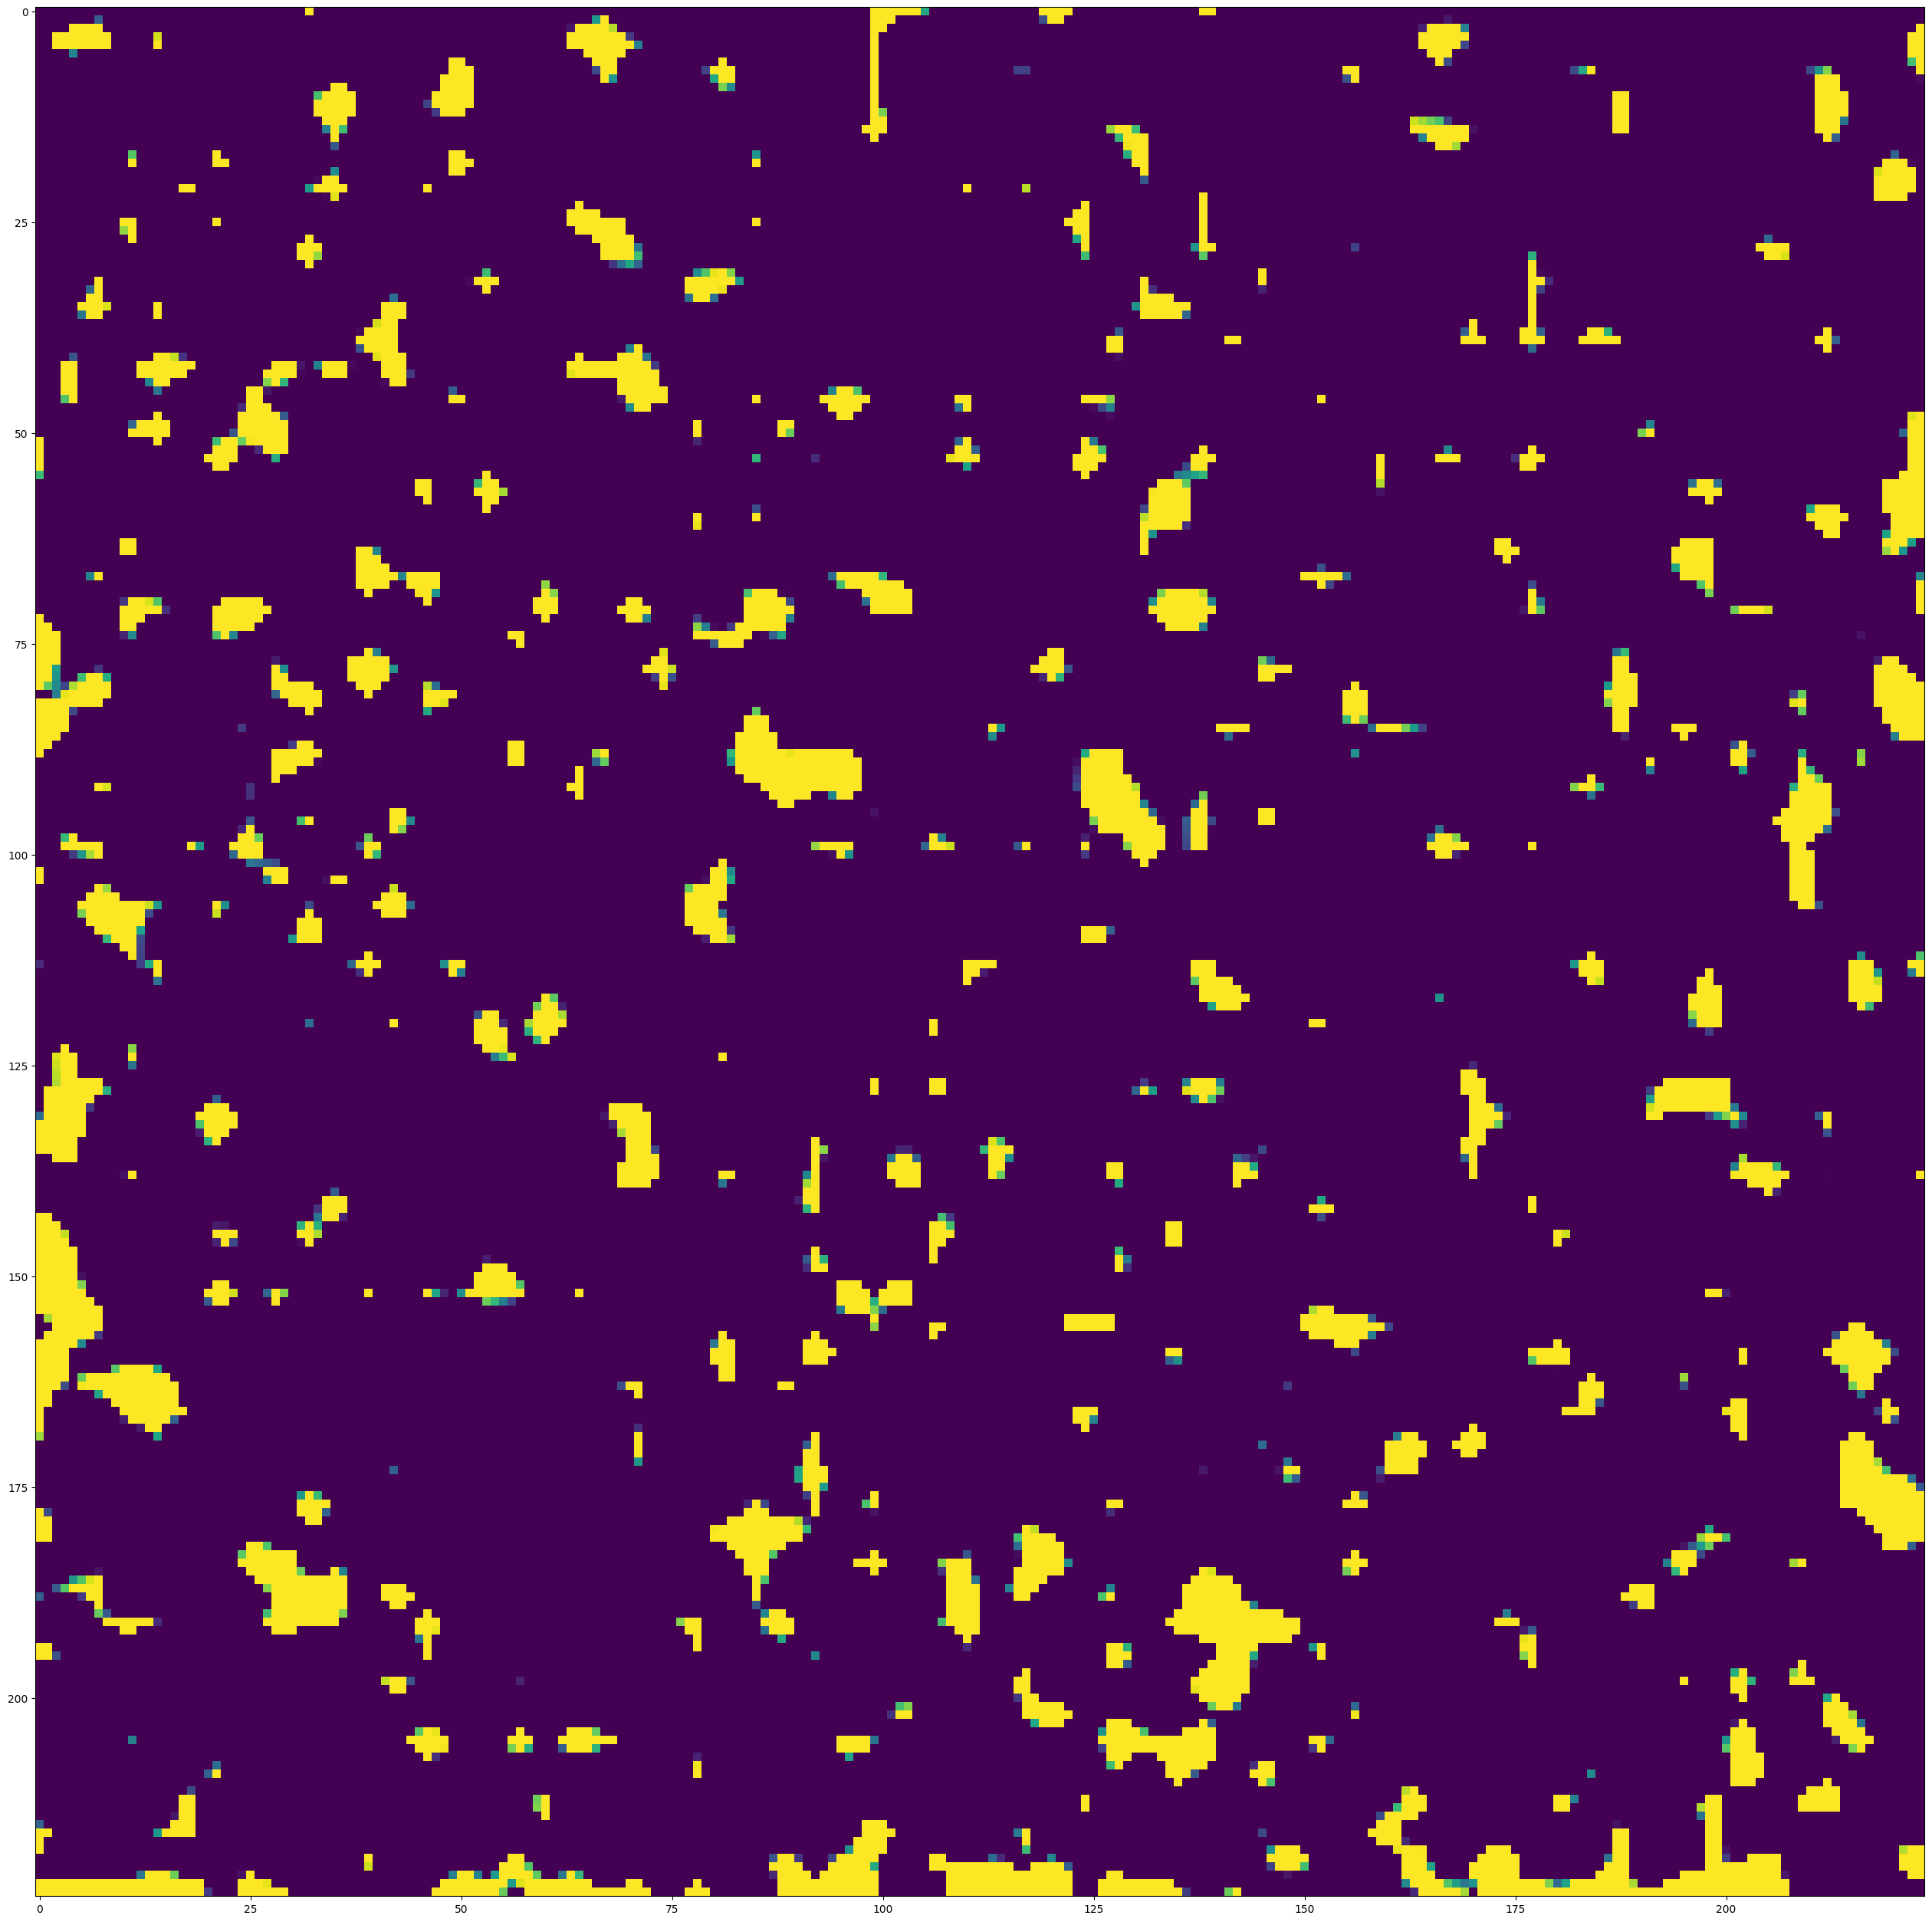

11:35:27 - INFO: Starting epoch 1:


  0%|          | 0/250 [00:00<?, ?it/s]

11:35:41 - INFO: Starting epoch 2:


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
from conditional_diffusion.ddpm_conditional import Diffusion
from conditional_diffusion.ddpm_conditional import SummaryWriter
from conditional_diffusion.ddpm_conditional import plot_images
from conditional_diffusion.ddpm_conditional import save_images  
from conditional_diffusion.modules import EMA
import os
import logging
import copy
# while len(tqdm._instances) > 0:
#     tqdm._instances.pop().close()
from tqdm.notebook import tqdm 

run_name = "Pong_Generator"

diffusion = Diffusion(img_size=64, device=device)
logger = SummaryWriter(os.path.join("runs", run_name))
# ema = EMA(0.995)
# ema_model = copy.deepcopy(net).eval().requires_grad_(False)
l = len(trainloader)

net.train()
for epoch in range(300):  # loop over the dataset multiple times

    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(trainloader, position=0,leave=True, ascii=True)


    for i, data in enumerate(pbar, 0):
        #print(i)
        input, truth = data
        small_images = truth[0] #64 by 64 image
        #images = truth[1] #224 by 224 image
        assert(small_images.size() == (batch_size,3,64,64), "size is " + str(small_images.size()))


        
        t = diffusion.sample_timesteps(small_images.shape[0]).to(device) #get <batch size> number of t's
        x_t, small_noise = diffusion.noise_images(small_images, t) #TODO change the random noise to not be reallocated in memory so that the time complexity is less.

        noise = big_transform(small_noise)#sadly i dont think this can be quickened

        use_embedding = True
        if np.random.random() < 0.1: #randomly dont use embedding to generate an image.
            use_embedding = False
        #forward
        small_predicted_noise, predicted_noise, rew, don = net(input, t = t, noised_truth = x_t, use_embedding = use_embedding)

        loss0 = small_img_criterion(small_noise,small_predicted_noise)
        loss1 = img_criterion(noise,predicted_noise)
        loss2 = rew_criterion(rew,truth[2])
        loss3 = don_criterion(don,truth[3])
        loss = loss0 + loss1 + loss2 + loss3

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ema.step_ema(ema_model, model)

        pbar.set_postfix(MSE=loss.item())
        logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    if epoch % 10 == 0:
        net.eval()
        labels = torch.arange(10).long().to(device)
        sampled_images = net(input[0].unsqueeze(0))[0]
        # ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
        plot_images(sampled_images)
        os.makedirs("results/{}".format(run_name), exist_ok = True)
        save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
        # save_images(ema_sampled_images, os.path.join("results", run_name, f"{epoch}_ema.jpg"))
        os.makedirs("models/{}".format(run_name), exist_ok = True)
        torch.save(net.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        # torch.save(ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
        net.train()

print('Finished Training')

In [ ]:
PATH = './models/pong_gen.pth'
torch.save(net.state_dict(), PATH)

In [25]:
net = Net(hidden_channels=hidden_channels)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [89]:
input = None
net.eval()
for i, data in enumerate(trainloader, 0):
    print(i)
    input, truth = data
    break

output = net(input[0].unsqueeze(0))[0]
print(output.shape)

0


999it [00:20, 48.82it/s]

torch.Size([1, 1, 224, 224])


In [90]:
from PIL import Image
image = Image.fromarray(input[0][0].cpu().detach().numpy())# true value
image.show()

image = Image.fromarray(output[0][0].cpu().detach().numpy())# predicted value
image.show()
print(output[0][0].cpu().detach().numpy())

[[  0 255 255 ... 194 255   0]
 [255 144   0 ... 194   0 164]
 [  0   0   0 ...   0   0 255]
 ...
 [194 194   0 ... 121   0 151]
 [  0   0   0 ...   0   0 255]
 [  0 255 255 ... 255 255   0]]


In [ ]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)

NameError: name 'observations' is not defined